lon [-87.881412, -87.650556, -85.9698, -86.136587, -86.053867]
lat [30.498001, 34.760556, 34.2888, 32.498567, 33.904039]
value [1, 1, 1, 1, 1]
Points data for Flag: {'lon': [-87.881412, -87.650556, -85.9698, -86.136587, -86.053867, -85.423117, -86.815, -86.915, -87.003611, -87.305556, -86.549167, -86.816667, -86.669167, -86.9425, -86.773889, -86.58637, -86.756174, -88.087526, -88.14114, -86.256367, -86.976939, -85.083841, -86.825, -88.201865, -87.459731, -109.466944, -111.652777, -112.153056, -111.1074, -113.58, -112.14257, -112.06626, -111.73331, -112.19196, -111.85272, -112.04601, -111.91721, -112.07533, -111.88431, -111.93473, -112.01739, -112.34184, -112.6207, -111.676928, -112.15732, -111.855654, -111.754616, -111.80505, -111.8378, -111.7987, -111.60925, -111.72529, -111.67183, -112.095767, -109.891944, -110.737116, -110.878667, -111.06352, -110.774357, -110.9823, -110.99644, -110.980112, -111.12716, -111.5436, -111.76225, -111.308056, -111.740108, -111.285594, -112.4761, -114.614

/home/esil/anaconda3/envs/devin_env/lib/python3.9/site-packages/esil/rsm_helper/model_property.py:75: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  self.lats, self.lons = transform(projection, 'EPSG:4326',grid_x, grid_y)
/home/esil/anaconda3/envs/devin_env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/esil/anaconda3/envs/devin_env/lib/python3.9/site-packages/esil/map_helper.py:928: RuntimeWarning: All-NaN slice encountered
  np.nanmin(grid_concentration),
/home/esil/anaconda3/envs/devin_env/lib/python3.9/site-packages/esil/map_helper.py:929: RuntimeWarning: All-NaN slice encountered
  np.nanmax(grid_concentration),
/home/esil/anaconda3/envs/devin_env/lib/python3.9/site-packages/esil/map_helper.py:930: RuntimeWarning: Mean of empty slice
  np.nanmean(grid_concentration),


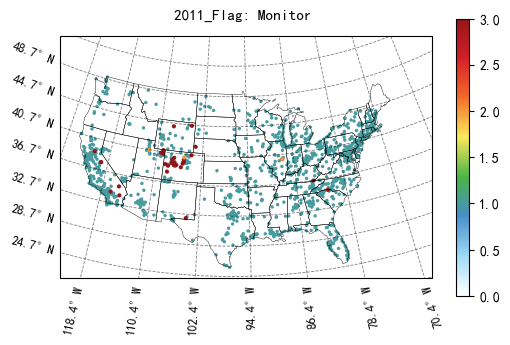

The data fusion plot for Flag is saved to /DeepLearning/mnt/shixiansheng/data_fusion/output/TestMap/Flag_Missing daily data.png
Done!


In [8]:
import os
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# for show maps
from esil.rsm_helper.model_property import model_attribute
from esil.map_helper import get_multiple_data, show_maps
import cmaps

cmap_delta = cmaps.ViBlGrWhYeOrRe
cmap_conc = cmaps.WhiteBlueGreenYellowRed

def plot_us_map(
    fusion_output_file,
    model_file,
    grid_column,  # 网格数据指定列
    monitor_column,  # 监测数据指定列
    save_path=None,
    boundary_json_file="/DeepLearning/mnt/Devin/boundary/USA_State.json",
    points_data=None,  # 点数据
    set_zero=True  # 添加参数来控制是否将浓度设置为零
):
    """
    description: plot the US map with different data fusion results
    @param {string} fusion_output_file: the data fusion output file
    @param {string} model_file: the model file used for data fusion
    @param {string} grid_column: 网格数据指定列
    @param {string} monitor_column: 监测数据指定列
    @param {string} save_path: the path to save the plot
    @param {string} boundary_json_file: the boundary file for the US map
    @param {dictionary} points_data: 点数据，包含经纬度和浓度值，default=None
    @param {bool} set_zero: 是否将浓度值设置为0，默认False
    @return None
    """
    # 注意
    mp = model_attribute(model_file)
    proj, longitudes, latitudes = mp.projection, mp.lons, mp.lats
    df_data = pd.read_csv(fusion_output_file)
    if grid_column not in df_data.columns:
        print(f"The data fusion file does not contain the {grid_column} column!")
        return
    layout = None

    # 移除对Period的依赖，不再有周期循环
    dict_data = {}

    # 检查是否存在指定列的数据
    if grid_column not in df_data.columns or df_data[grid_column].empty:
        print(f"No data found in {grid_column}. Skipping.")
        return

    # 将网格浓度全部设为nan
    grid_concentration_model = np.full(longitudes.size, np.nan)
    grid_concentration_model = grid_concentration_model.reshape(longitudes.shape)

    vmax_conc = np.nanpercentile(grid_concentration_model, 99.5)
    vmin_conc = np.nanpercentile(grid_concentration_model, 0.5)
    value_range = [0,3]

    # 提取特定列的点数据
    points_data_period = points_data.get(monitor_column, None)
    if points_data_period:
        # 设定点大小为15,以及指定颜色
        # points_data_period['symbol_size'] = [6] * len(points_data_period['lon'])
        # # 根据 Flag 值设置点大小
        symbol_sizes = [6 if flag == 1 else 9 for flag in points_data[monitor_column]['value']]
        points_data[monitor_column]['symbol_size'] = symbol_sizes
        points_data_period['edgecolor'] = 'None'
        points_data_period['cmaq'] = 'jet',
        print(f"Points data for {monitor_column}: {points_data_period}")
        # 添加点数据到dict_data
        get_multiple_data(
            dict_data,
            dataset_name=f"2011_{monitor_column}: Monitor",
            variable_name="",
            grid_x=longitudes,
            grid_y=latitudes,
            grid_concentration=grid_concentration_model,
            points_data=points_data_period  # 传入点数据
        )
    else:
        print(f"No points data found for {monitor_column}")

    fig = show_maps(
        dict_data,
        cmap=cmap_conc,
        unit="",
        show_lonlat=True,
        projection=proj,
        is_wrf_out_data=True,
        boundary_file=boundary_json_file,
        show_original_grid=True,
        show_grid_line=True,
        panel_layout=layout,
        show_minmax=False,
        # delta_map_settings={
        #     "cmap": 'jet',
        #     "value_range": (5, 50),
        #     "colorbar_ticks_num": None,
        #     "colorbar_ticks_value_format": ".2f",
        #     "value_format": ".2f",
        # },
        title_fontsize=11,
        xy_title_fontsize=9,
        show_dependenct_colorbar=True,
        value_range=value_range,
    )

    if save_path is not None:
        save_file = os.path.join(save_path, f"{monitor_column}_Missing daily data.png")
        fig.savefig(save_file, dpi=600)
        print(f"The data fusion plot for {monitor_column} is saved to {save_file}")
    dict_data = {}


if __name__ == "__main__":
    save_path = r"/DeepLearning/mnt/shixiansheng/data_fusion/output/TestMap"
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    model_file = r"/backupdata/data_EPA/EQUATES/EQUATES_data/HR2DAY_LST_ACONC_v532_cb6r3_ae7_aq_WR413_MYR_STAGE_2011_12US1_2011.nc"
    data_fusion_file = r"/DeepLearning/mnt/shixiansheng/data_fusion/output/Region/ROWCOLRegion_Tz_CONUS_ST.csv"

    points_data_df = pd.read_csv('/DeepLearning/mnt/shixiansheng/data_fusion/output/2011_Data_WithoutCV/2011_Monitor_Hourlvvs.DailyFlag.csv')
    points_data = {}
    monitor_column = 'Flag'  # 监测数据指定列
    grid_column = 'gmt_offset'  # 网格数据指定列

    # 过滤掉极端的经纬度，远离美国陆地外的监测站
    filtered_df = points_data_df[(points_data_df['Lon'] >= -134.4) & (points_data_df['Lon'] <= -70)]
    # 提取需要的列数据到 points_data 字典中
    points_data[monitor_column] = {
        'lon': filtered_df['Lon'].tolist(),
        'lat': filtered_df['Lat'].tolist(),
        'value': filtered_df[monitor_column].tolist(),
    }

    # 打印前五行数据
    for key in points_data[monitor_column]:
        print(key, points_data[monitor_column][key][:5])

    for file in [data_fusion_file]:
        plot_us_map(file, model_file, grid_column, monitor_column, save_path, points_data=points_data, set_zero=True)
    print("Done!")